### This notebook reproduces the figures in Badman+2023 "_Prediction and Verification of Parker Solar Probe Solar Wind Sources at 13.3 $R_\odot$_"

Before you run this, ensure you have the following software installed (if you do not, just do `$> pip install <package_name> `):

`astropy, astrospice, func_timeout, matplotlib, numpy, pandas, pfsspy, pyspedas, scipy, streamtracer, sunpy`

This notebook has been tested with the following software versions :

`astropy==5.1`

`astrospice==0.2.0`

`func_timeout==4.3.5`

`matplotlib==3.5.2`

`numpy==1.21.5`

`pandas==1.4.4`

`pfsspy==1.1.2`

`pyspedas==1.4.18`

`scipy==1.9.1`

`streamtracer==1.2.0`

`sunpy==4.1.0`

You may also need to install `drms` and `zeep`. For any issues with numpy, you might need to upgrade numba:

`pip install --ignore-installed llvmlite==0.36`

`pip install numba==0.53`

You may shortcut the above installation with `pip install -r requirements.txt`. Note, if you have any higher versions of these packages, this would revert them to the versions shown above.

__Windows Users__ : You may need to install the v2.0.0 pre-release of streamtracer : `pip install streamtracer --pre` or `pip install streamtracer==2.0.0a1` (See https://github.com/dstansby/streamtracer/issues/61)

This directory also contains two submodules : [solarsynoptic](https://github.com/dstansby/solarsynoptic.git) and [kent_distribution](https://github.com/edfraenkel/kent_distribution). Note the copy of `kent_distribution` referenced here is a [fork](https://github.com/STBadman/kent_distribution/tree/master) from my github with edits to make it work in python 3.0 (print commands edited). __You will need to use git submodule to pull them correctly__ From the folder where this notebook is located, run:  `$> git submodule update --init`


When you think you have all the packages installed, try running this cell:

In [1]:
# Check modules are installed
import astropy, astrospice, func_timeout, matplotlib, numpy, pandas, pfsspy, pyspedas, pytplot, scipy, streamtracer, sunpy

If the cell worked without any issues, you should be good to go! Just click `Cell`>`Run All`

Note that this will download about 400MB of data from GONG, SDO and PSP, and you will need an internet connection. _Note_: There have been some issues reported with downloading via pyspedas on some internet connections. If you have issues, try using a VPN to an alternative network. 

In [2]:
### Imports
import matplotlib.pyplot as plt, numpy as np, pandas as pd
import pyspedas, pytplot, pfsspy, astrospice, sys, glob, os
import sunpy.map, sunpy.coordinates 
import astropy.coordinates
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u
import astrospice
from datetime import datetime, timedelta
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
from pathlib import Path
import urllib.request
import matplotlib.patches as mpatch

# Solar Synoptic ($> git clone https://github.com/dstansby/solarsynoptic.git)
sys.path.append("./solarsynoptic/")
from solarsynoptic.combine import coadd, weights_longitude
from solarsynoptic.data import aia_start_of_day_map, stereo_start_of_day_map
from solarsynoptic.reprojection.reprojection import reproject_carrington, carrington_header
def weight_function(smap):
    weights = weights_longitude(30 * u.deg)(smap)
    factor = (datetime.now() - smap.date.to_datetime()) / timedelta(days=1)
    return weights / factor

# Kent distribution library ( $> git clone https://github.com/edfraenkel/kent_distribution )
sys.path.append("./kent_distribution/")
import kent_distribution as kd
def edges(arr) : return (arr[:-1] + arr[1:])/2
def get_centroid(kent_dist) :
    """From a given Kent_Distribution, retrieve the latitude and longitude of the centroid"""
    x = np.cos(kent_dist.theta)
    y = np.sin(kent_dist.theta)*np.cos(kent_dist.phi)
    z = np.sin(kent_dist.theta)*np.sin(kent_dist.phi)
    lat = np.degrees(np.arcsin(z))
    lon = np.degrees(np.arctan2(y,x) % (2*np.pi))
    return lon,lat
import func_timeout
def edges(arr) : return (arr[:-1] + arr[1:])/2
@func_timeout.func_set_timeout(0.1)
def fit_kent_mle(samples) : return kd.kent_mle(samples)
@func_timeout.func_set_timeout(0.1)
def fit_kent_me(samples) : return kd.kent_me(samples)
@func_timeout.func_set_timeout(0.5)
def test_kent(k) : _=k.rvs(int(1e4))

# Load in PSP/SolO Spice Kernels (download happens automatically)
kernels= [astrospice.registry.get_kernels(sc,'predict') 
          for sc in ["psp","solar orbiter"]]

### Helper functions (./helpers.py)
import helpers as h

# Time bounds for central period of interest (super-corotation)
tfocus = [datetime(2021,11,17),datetime(2021,11,26),]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

01-Feb-23 15:17:39: /home/sbadman/anaconda3/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),



Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

# Prediction and Verification of Parker Solar Wind Sources at 13.3Rs

Drawing connections between heliospheric spacecraft and solar wind sources is a vital step in understanding the evolution of the solar corona into the solar wind and contextualizing in situ timeseries. Furthermore, making advanced predictions of this linkage for ongoing heliospheric missions, such as Parker Solar Probe (PSP), is extremely useful  for achieving useful coordinated remote observations and maximising the science return on these missions.  The general procedure for estimating connectivity from a given solar wind and coronal model is straightforward (magnetic field line tracing) but validating these estimates is far from trivial due to the lack of an independent ground truth and limited model constraints. In its most recent orbits, PSP has reached perihelia of 13.3Rs and moreover travels extremely fast prograde relative to the solar surface, covering more than 100 degrees longitude in 2 days. Here we present footpoint predictions and subsequent validation efforts for PSP Encounter 10 which occurred in November 2021. We show that the longitudinal dependence of in situ plasma data from these novel orbits provides a powerful method of verification of source mapping.  With reference to prior and subsequent encounters we also show the conditions under which source mapping is most accurate (for a near-ecliptic spacecraft) occurs when solar activity is low, but the heliospheric current sheet is strongly warped by mid-latitude or equatorial coronal holes from decaying active regions. Lastly, we comment on the large scale coronal structure implied by the Encounter 10 mapping, highlighting an equatorial cut of the Alfven surface consisting of localized protrusions above magnetic separatrices.

### Figure 1 : 13.3 Rs orbit family

Plot to illustrate (1) The geometry of PSP's orbits in inertial vs co-rotating coordinates, (2) Highlight the 13.3Rs orbit family and comment on how large a longitudinal range around the Sun

In [3]:
### Generate timestamps for the whole mission
dt_mission = h.gen_dt_arr(datetime(2018,8,15),
                        datetime(2022,10,24),
                        cadence_days=1/24)
### Create SkyCoord for PSP in the inertial (J2000) frame
psp_mission_inertial = astrospice.generate_coords(
    'SOLAR PROBE PLUS',dt_mission
)
### Transform to solar co-rotating frame (SLOW)
psp_mission_carrington = psp_mission_inertial.transform_to(
    sunpy.coordinates.HeliographicCarrington(observer="self")
)

In [4]:
### Get aphelia dates and indices to segment trajectory by encounter
psp_mission_carrington.representation_type="spherical"
aphelia = dt_mission[argrelextrema(
    psp_mission_carrington.radius,np.greater
)]
perihelia = dt_mission[argrelextrema(
    psp_mission_carrington.radius,np.less
)]
split_inds = [np.where(dt_mission >ap)[0][0] for ap in aphelia] 

### Do segmentation
dt_by_orb = np.split(dt_mission,split_inds)
psp_inertial_by_orb = np.split(psp_mission_inertial,split_inds)
psp_carrington_by_orb = np.split(psp_mission_carrington,split_inds)

### Extract E01, E04 and E10
dt_e01 = dt_by_orb[0]
psp_inertial_e01 = psp_inertial_by_orb[0]
psp_carrington_e01 = psp_carrington_by_orb[0]

dt_e04 = dt_by_orb[3]
psp_inertial_e04 = psp_inertial_by_orb[3]
psp_carrington_e04 = psp_carrington_by_orb[3]

dt_e10 = dt_by_orb[9]
psp_inertial_e10 = psp_inertial_by_orb[9]
psp_carrington_e10 = psp_carrington_by_orb[9]

for psp in [psp_inertial_e01,psp_inertial_e10,
            psp_carrington_e01,psp_carrington_e10] :
    psp.representation_type="cartesian"

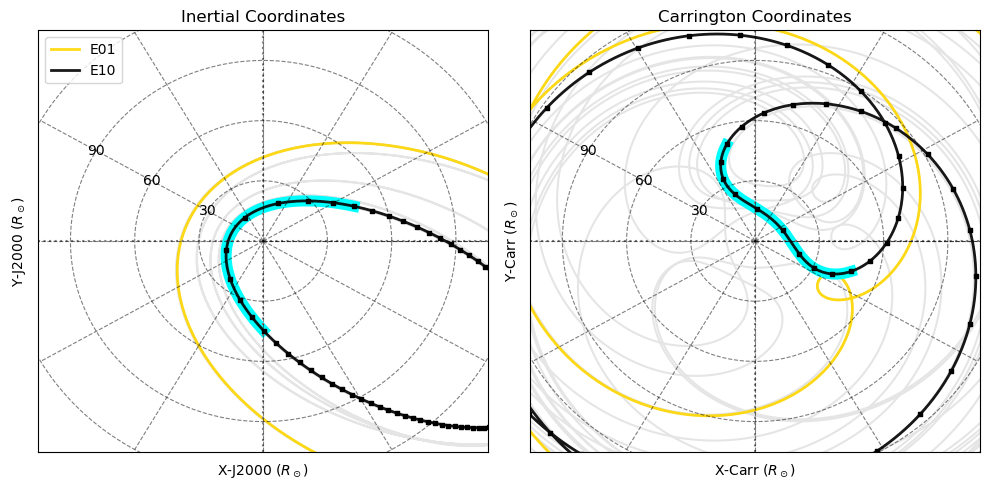

In [5]:
fig,axes = plt.subplots(figsize=(10,5),ncols=2,
                        sharex=True,sharey=True)

inds_focus = (dt_e10 > tfocus[0]) & (dt_e10 < tfocus[-1])

## Inertial
psp_mission_inertial.representation_type="cartesian"
axes[0].plot(psp_mission_inertial.x.to("R_sun"),
             psp_mission_inertial.y.to("R_sun"),
             color="black",alpha=0.1)
axes[0].plot(psp_inertial_e01.x.to("R_sun"),
             psp_inertial_e01.y.to("R_sun"),
             label="E01",
             color="gold",alpha=0.9,linewidth=2,linestyle="-")
axes[0].plot(psp_inertial_e10.x.to("R_sun"),
             psp_inertial_e10.y.to("R_sun"),
             label="E10",
             color="black",alpha=0.9,linewidth=2, zorder=3)
axes[0].plot(psp_inertial_e10.x.to("R_sun")[inds_focus],
             psp_inertial_e10.y.to("R_sun")[inds_focus],
             color="cyan",alpha=1,linewidth=8,zorder=2)
axes[0].scatter(psp_inertial_e10.x.to("R_sun")[::24],
             psp_inertial_e10.y.to("R_sun")[::24],
             marker="s",color="black",s=10, zorder=3)
axes[0].set_xlabel("X-J2000 ($R_\odot$)")
axes[0].set_ylabel("Y-J2000 ($R_\odot$)")
axes[0].legend()
axes[0].set_title("Inertial Coordinates")

psp_mission_carrington.representation_type="cartesian"
axes[1].plot(psp_mission_carrington.x.to("R_sun"),
             psp_mission_carrington.y.to("R_sun"),
             color="black",alpha=0.1)
axes[1].plot(psp_carrington_e01.x.to("R_sun"),
             psp_carrington_e01.y.to("R_sun"),
             color="gold",alpha=0.9,linewidth=2,linestyle="-")
axes[1].plot(psp_carrington_e10.x.to("R_sun"),
             psp_carrington_e10.y.to("R_sun"),
             color="black",alpha=0.9,linewidth=2,zorder=3)
axes[1].plot(psp_carrington_e10.x.to("R_sun")[inds_focus],
             psp_carrington_e10.y.to("R_sun")[inds_focus],
             color="cyan",alpha=1,linewidth=8,zorder=2)
axes[1].scatter(psp_carrington_e10.x.to("R_sun")[::24],
             psp_carrington_e10.y.to("R_sun")[::24],
             color="black",marker='s',s=10,zorder=3)
axes[1].set_xlabel("X-Carr ($R_\odot$)")
axes[1].set_ylabel("Y-Carr ($R_\odot$)")
axes[1].set_title("Carrington Coordinates")

for ax in axes:
    ax.axvline(0,color="grey",linestyle=":")
    ax.axhline(0,color="grey",linestyle=":")
    ## Polar gridlines 
    for R_ in np.linspace(30,120,4) :
        ax.plot(R_*np.cos(np.linspace(0,2*np.pi,200)),
                R_*np.sin(np.linspace(0,2*np.pi,200)),
                color="black",linestyle="--",alpha=0.5,linewidth=0.8
               )
        if R_ < 120 : ax.text(R_*np.cos(np.radians(150)),
                              R_*np.sin(np.radians(150)),
                              f"{R_:.0f}",
                              horizontalalignment="center",
                              verticalalignment="center"
                             )

    for phi in np.radians(np.linspace(0,360,13)) :
        ax.plot([0,120*np.cos(phi)],[0,120*np.sin(phi)],
                color="black",linestyle="--",alpha=0.5,linewidth=0.8
               )
    ax.set_xlim([-105,105])
    ax.set_ylim([-105,105])
    ax.set_xticks([])
    ax.set_yticks([])
    
        
plt.tight_layout()

plt.savefig("./Figure1.png",dpi=200)

### Intermediate Step : Load in all prediction data for E04 and E10

For each encounter, we read in all csv files that were archived during the prediction campaigns for each day that there was an update. For each day's update, we bin the time horizon of the predictions into 6 hour chunks. For each 6 hour chunk we collect or longitude and latitude values (as well as the name of file that they come from), and store these as dataframes. Each of these dataframes is the input to a given "consensus" prediction, containing the information needed to construct the ensemble from which a centroid and error is extracted. 

In [6]:
predictions_dict = {}
csvpath = f"./CSV" 
for enc in ["E04","E10"] :
    csv_folders = sorted(glob.glob(f"{csvpath}/{enc}/*"))
    csv_dates = [datetime.strptime(os.path.basename(folder),"%Y%m%d") 
                 for folder in csv_folders]
    update_dict = {}
    for folder,date in zip(csv_folders,csv_dates) :
        wsa_fnames = sorted(glob.glob(f"{folder}/wsa*.csv"))
        ucb_fnames = sorted(glob.glob(f"{folder}/UCB*.csv"))
        psi_fnames = sorted(glob.glob(f"{folder}/PSI*.csv"))
        uah_fnames = sorted(glob.glob(f"{folder}/UAH*.csv"))
        nso_fnames = sorted(glob.glob(f"{folder}/NSO*.csv"))
        all_fnames = wsa_fnames+ucb_fnames+psi_fnames+uah_fnames+nso_fnames
        ## Read all data and bin into 6 hour chunks
        days = np.array(h.gen_dt_arr(date,
                                   date+timedelta(days=30),
                                   cadence_days=6/24))
        distrib_dict = dict(zip(days,[{"lons":[],
                                       "lats":[],
                                       "fnames":[]} 
                                      for _ in range(len(days))]))

        for ii,fname in enumerate(all_fnames) :
            df = pd.read_csv(fname,index_col=[0,1])
            if (df.columns[0] != "lon" 
                and df.columns[0] != "lon(GONG)"):
                df.columns = ["lon","lat"]
                df.index.names = ["date","time"]

            datetimes = np.array([
                pd.to_datetime(tup[0]+' '+tup[1]).to_pydatetime() 
                for tup in df.index
                                 ])
            lon = df['lon'].values
            lat = df['lat'].values
            for jj,(day,dayp) in enumerate(zip(days[:-1],days[1:])):
                wh = np.where((datetimes >= day) & 
                              (datetimes < dayp))[0]
                if len(wh) > 0 :
                    distrib_dict[day]["lons"].extend(lon[wh])
                    distrib_dict[day]["lats"].extend(lat[wh])
                    distrib_dict[day]["fnames"].extend(
                        [os.path.basename(fname).lower()]*len(wh)
                    )
        for day in days :
            distrib_dict[day] = pd.DataFrame(distrib_dict[day])
        update_dict[date] = distrib_dict
    predictions_dict[enc] = update_dict

### Figure 2 : Consensus Fitting

Plot to illustrate (by way of example with real prediction data from E10) how we use an ensemble of predicted source latitudes and longitudes to fit a 2D distribution (the Kent distribution) and thereby extract a source centroid and some information about the spread in the predictions (the FWHM contour).

In [7]:
# First extract one of the dataframes packaged above to 
# be our example input distribution
### We choose an example from E10, from the 2021/11/11 update, 
### for the 2021/11/15T(0600-1200) interval
enc = "E10"
update = datetime(2021,11,15)
window = datetime(2021,11,20,6)
distribution = predictions_dict[enc][update][window]
distribution

,lons,lats,fnames
0,341.741000,-25.621700,wsa_e10_202111150800a_ahmifield_line1r000.csv
1,342.210000,-25.631000,wsa_e10_202111150800a_ahmifield_line1r000.csv
2,343.010000,-25.714200,wsa_e10_202111150800a_ahmifield_line1r000.csv
3,343.336000,-25.760600,wsa_e10_202111150800a_ahmifield_line1r000.csv
4,342.112000,-25.841000,wsa_e10_202111150800a_ahmifield_line1r001.csv
...,...,...,...
210,343.639698,-28.914869,uah_psp_e10_20211112j_ahmiwsamhd.csv
211,345.560317,-25.587302,uah_psp_e10_20211112k_agongwsamhd.csv
212,343.101576,-27.506596,uah_psp_e10_20211112k_ahmiwsamhd.csv
213,344.140413,-24.484760,uah_psp_e10_20211112l_agongwsamhd.csv


In [8]:
## For context, download aia data for the date the predictions were issued
aiamap = aia_start_of_day_map(update,211*u.angstrom)

## Create a SkyCoord for the source positions which can be projected onto aiamap
ensemble = h.carr2SkyCoord(distribution.lons.values*u.deg,
                         distribution.lats.values*u.deg,
                         [1*u.R_sun]*len(distribution),
                         update
                        )

In [9]:
### Fit a Kent distribution to the ensemble
ensemble.representation_type="cartesian"
cart_ensemble = np.array([ensemble.x.to("R_sun").value,
                          ensemble.y.to("R_sun").value,
                          ensemble.z.to("R_sun").value])
cart_ensemble /= np.linalg.norm(cart_ensemble,axis=0)
kent_fit = kd.kent_mle(cart_ensemble.T)

# Retrieve the centroid
centroid = get_centroid(kent_fit)

# Cast to a SkyCoord
centroid_sc = h.carr2SkyCoord(centroid[0]*u.deg,
                            centroid[1]*u.deg,
                            1*u.R_sun,
                            update)

In [10]:
# Create sunpy map of distribution (Carrington frame)
# Note map grid points are pixel centers.
uc,vc = np.meshgrid(np.linspace(0.5,359.5,360)*u.deg,
                    np.linspace(-89.5,89.5,180)*u.deg)
xc,yc,zc = np.array([[np.cos(uc)*np.cos(vc)],
                     [np.sin(uc)*np.cos(vc)],
                     [np.sin(vc)]
                    ])
pdf_sampled = kent_fit.pdf(np.array([xc,yc,zc]).T)

carr_header = sunpy.map.header_helper.make_heliographic_header(
    update, aiamap.observer_coordinate, [180,360], frame="carrington"
)
carr_header["crval1"] = 180 # Make sunpy realize left hand edge is 0 deg lon
pdf_map = sunpy.map.Map(pdf_sampled.T,carr_header)

# Reproject back to helioprojective view #SLOW#
pdf_map_helioproj = pdf_map.reproject_to(aiamap.wcs)

01-Feb-23 15:18:37: /home/sbadman/anaconda3/lib/python3.9/site-packages/sunpy/map/mapbase.py:213: SunpyUserWarning: This file contains more than 2 dimensions. Data will be truncated to the first two dimensions.
  warn_user("This file contains more than 2 dimensions. "



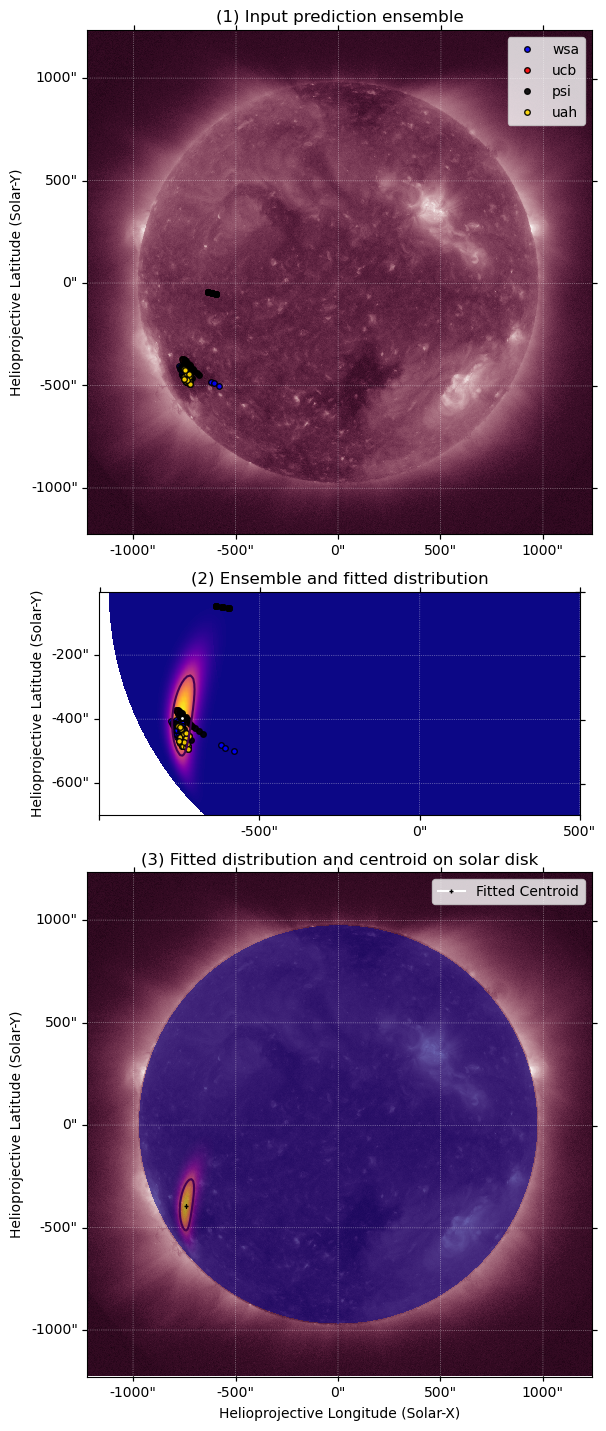

In [11]:
source_dict = {"wsa":"blue",
               "ucb":"red",
               "psi":"black",
               "uah":"gold",
              }#"nso":"green"}

## Create Plot
fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(5, 1)

ax1 = fig.add_subplot(gs[0:2],projection=aiamap)
aiamap.plot(axes=ax1)


ax2 = fig.add_subplot(gs[3:],projection=aiamap)
aiamap.plot(axes=ax2)

pdf_map_helioproj.plot(cmap="plasma",
                       axes=ax2,alpha=0.6,
                       clip_interval=[95,100]*u.percent)
ax2.plot_coord(centroid_sc,
               marker="+",ms=3,mec="black",linestyle=None,
               color="white",label="Fitted Centroid",zorder=10)
ax2.legend()


ax3=fig.add_subplot(gs[2:3],projection=aiamap)

pdf_map_helioproj.plot(cmap="plasma",
                       axes=ax3,alpha=1,
                       clip_interval=[95,100]*u.percent)
ax3.plot_coord(centroid_sc,
               marker="o",ms=3,mec="black",linestyle=None,
               color="white",label="Fitted Centroid",zorder=10)
xpixel_lims,ypixel_lims = h.get_pixel_lims([-1000, 500]*u.arcsec,
                                         [-700, 0]*u.arcsec,
                                         pdf_map_helioproj,
                                         ax3)
ax3.set_xlim(xpixel_lims)
ax3.set_ylim(ypixel_lims)
for ax in [ax1,ax3]:
    for source,col in source_dict.items() :
        filter_ = distribution.fnames.str.contains(source)
        if np.nansum(filter_) > 1 :
            ax.plot_coord(ensemble[filter_],
                          "o",ms=4,alpha=0.9,c=col,label=source,
                          mec="black",linestyle="none"
                         )
pdf_map_helioproj.draw_contours(
    axes=ax2,
    levels=[np.nanmax(pdf_map_helioproj.data.flatten())/2]
)
pdf_map_helioproj.draw_contours(
    axes=ax3,
    levels=[np.nanmax(pdf_map_helioproj.data.flatten())/2]
)

ax1.legend()

ax1.set_title("(1) Input prediction ensemble")
ax3.set_title("(2) Ensemble and fitted distribution")
ax2.set_title("(3) Fitted distribution and centroid on solar disk")
ax1.set_xlabel(" ")
ax3.set_xlabel(" ")
plt.tight_layout(pad=-6)

plt.savefig("./Figure2.png",dpi=200,bbox_inches="tight")

### Figure 3 : E10 Prediction Outcomes

Plot to illustrate/summarize the Encounter 10 prediction data : how did different models/magnetograms differ (not much for E10) and what was the overall consensus prediction? How did the predictions evolve with prediction updates?

In [12]:
# First, fit a distribution to all the 6-hour-window ensembles
enc = "E10"
update = datetime(2021,11,15)

centroids = []
fwhm_contours = []
windows_with_data = []
fit_success = []
for window,distribution in predictions_dict[enc][update].items():
    sys.stdout.write(f"{window}\r")
    if (len(distribution) > 10) & (window > tfocus[0]) & (window < tfocus[-1]): 
        # Cast Ensemble to SkyCoord
        ensemble = h.carr2SkyCoord(distribution.lons.values*u.deg,
                                 distribution.lats.values*u.deg,
                                 [1*u.R_sun]*len(distribution),
                                 update
                                )
        ### Fit a Kent distribution to the ensemble
        ensemble.representation_type="cartesian"
        cart_ensemble = np.array([ensemble.x.to("R_sun").value,
                                  ensemble.y.to("R_sun").value,
                                  ensemble.z.to("R_sun").value])
        cart_ensemble /= np.linalg.norm(cart_ensemble,axis=0)

        try :
            kent_fit = fit_kent_mle(cart_ensemble.T)
            test_kent(kent_fit)
            centroids.append(get_centroid(kent_fit))
            fit_success.append("MLE")
        except : 
            try : 
                kent_fit = fit_kent_me(cart_ensemble.T)
                test_kent(kent_fit)
                centroids.append(get_centroid(kent_fit))
                fit_success.append("ME")
            except :
                kent_fit=None
                centroids.append([
                    np.nanmedian(distribution.lons.values),
                    np.nanmedian(distribution.lats.values)
                ])
                fit_success.append("Fail")
        if kent_fit is not None :
            pdf_sampled = kent_fit.pdf(np.array([xc,yc,zc]).T)         
            header = sunpy.map.header_helper.make_heliographic_header(
                update, aiamap.observer_coordinate, [180,360], frame="carrington"
            )
            header["crval1"] = 180
            pdf_map = sunpy.map.Map(pdf_sampled.T,header)
            fwhm_contours.append(pdf_map.contour(
                np.nanmax(pdf_map.data.flatten())/2
            ))
        else : fwhm_contours.append(None)            
        windows_with_data.append(window)

# Cast to SkyCoords
centroids_sc = h.carr2SkyCoord(np.array(centroids)[:,0]*u.deg,
                             np.array(centroids)[:,1]*u.deg,
                             [1*u.R_sun]*len(centroids),
                             update)

01-Feb-23 15:19:50: /home/sbadman/1_RESEARCH/Postdoc-SAO/PSP-Sources-Paper/PSP-E10-Sources/./kent_distribution/kent_distribution.py:212: RuntimeWarning: invalid value encountered in double_scalars
  a /= G(j+1)

01-Feb-23 15:19:50: /home/sbadman/1_RESEARCH/Postdoc-SAO/PSP-Sources-Paper/PSP-E10-Sources/./kent_distribution/kent_distribution.py:213: RuntimeWarning: invalid value encountered in double_scalars
  a *= G(j+0.5)

01-Feb-23 15:19:51: /home/sbadman/1_RESEARCH/Postdoc-SAO/PSP-Sources-Paper/PSP-E10-Sources/./kent_distribution/kent_distribution.py:277: RuntimeWarning: overflow encountered in exp
  return exp(self.log_pdf(xs, normalize))

01-Feb-23 15:19:51: /home/sbadman/1_RESEARCH/Postdoc-SAO/PSP-Sources-Paper/PSP-E10-Sources/./kent_distribution/kent_distribution.py:238: RuntimeWarning: overflow encountered in exp
  return exp(self.log_pdf_max(normalize))



01-Feb-23 15:19:54: /home/sbadman/anaconda3/lib/python3.9/site-packages/sunpy/map/mapbase.py:213: SunpyUserWarning: This file contains more than 2 dimensions. Data will be truncated to the first two dimensions.
  warn_user("This file contains more than 2 dimensions. "



01-Feb-23 15:19:55: /home/sbadman/anaconda3/lib/python3.9/site-packages/sunpy/map/mapbase.py:213: SunpyUserWarning: This file contains more than 2 dimensions. Data will be truncated to the first two dimensions.
  warn_user("This file contains more than 2 dimensions. "

01-Feb-23 15:19:55: /home/sbadman/1_RESEARCH/Postdoc-SAO/PSP-Sources-Paper/PSP-E10-Sources/./kent_distribution/kent_distribution.py:352: RuntimeWarning: invalid value encountered in double_scalars
  dk += (

01-Feb-23 15:19:55: /home/sbadman/1_RESEARCH/Postdoc-SAO/PSP-Sources-Paper/PSP-E10-Sources/./kent_distribution/kent_distribution.py:362: RuntimeWarning: invalid value encountered in double_scalars
  2*j*exp(

01-Feb-23 15:19:55: /home/sbadman/1_RESEARCH/Postdoc-SAO/PSP-Sources-Paper/PSP-E10-Sources/./kent_distribution/kent_distribution.py:359: RuntimeWarning: invalid value encountered in double_scalars
  dk *= G(j+0.5)

01-Feb-23 15:19:55: /home/sbadman/1_RESEARCH/Postdoc-SAO/PSP-Sources-Paper/PSP-E10-Sources/./kent_

01-Feb-23 15:19:58: /home/sbadman/anaconda3/lib/python3.9/site-packages/sunpy/map/mapbase.py:213: SunpyUserWarning: This file contains more than 2 dimensions. Data will be truncated to the first two dimensions.
  warn_user("This file contains more than 2 dimensions. "



01-Feb-23 15:19:58: /home/sbadman/anaconda3/lib/python3.9/site-packages/sunpy/map/mapbase.py:213: SunpyUserWarning: This file contains more than 2 dimensions. Data will be truncated to the first two dimensions.
  warn_user("This file contains more than 2 dimensions. "



01-Feb-23 15:20:02: /home/sbadman/1_RESEARCH/Postdoc-SAO/PSP-Sources-Paper/PSP-E10-Sources/./kent_distribution/kent_distribution.py:212: RuntimeWarning: invalid value encountered in double_scalars
  a /= G(j+1)

01-Feb-23 15:20:02: /home/sbadman/1_RESEARCH/Postdoc-SAO/PSP-Sources-Paper/PSP-E10-Sources/./kent_distribution/kent_distribution.py:213: RuntimeWarning: invalid value encountered in double_scalars
  a *= G(j+0.5)

01-Feb-23 15:20:02: /home/sbadman/1_RESEARCH/Postdoc-SAO/PSP-Sources-Paper/PSP-E10-Sources/./kent_distribution/kent_distribution.py:277: RuntimeWarning: overflow encountered in exp
  return exp(self.log_pdf(xs, normalize))

01-Feb-23 15:20:02: /home/sbadman/1_RESEARCH/Postdoc-SAO/PSP-Sources-Paper/PSP-E10-Sources/./kent_distribution/kent_distribution.py:238: RuntimeWarning: overflow encountered in exp
  return exp(self.log_pdf_max(normalize))



Note that in the next cell, we download 28 full sun EUV images, each about ~10MB. This can take a little while in python. Once the download has been done once, it won't repeat so this cell will be quicker to re-run.

01-Feb-23 15:20:10: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:10: Fetching reprojected AIA 211.0 Angstrom 2021-11-07 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-07 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:10: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:10: Fetching reprojected AIA 211.0 Angstrom 2021-11-08 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-08 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:11: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:11: Fetching reprojected AIA 211.0 Angstrom 2021-11-09 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-09 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:11: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:11: Fetching reprojected AIA 211.0 Angstrom 2021-11-10 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-10 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:12: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:12: Fetching reprojected AIA 211.0 Angstrom 2021-11-11 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-11 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:13: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:13: Fetching reprojected AIA 211.0 Angstrom 2021-11-12 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-12 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:13: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:13: Fetching reprojected AIA 211.0 Angstrom 2021-11-13 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-13 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:13: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:13: Fetching reprojected AIA 211.0 Angstrom 2021-11-14 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-14 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:14: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:14: Fetching reprojected AIA 211.0 Angstrom 2021-11-15 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-15 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:15: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:15: Fetching reprojected AIA 211.0 Angstrom 2021-11-16 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-16 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:15: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:15: Fetching reprojected AIA 211.0 Angstrom 2021-11-17 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-17 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:16: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:16: Fetching reprojected AIA 211.0 Angstrom 2021-11-18 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-18 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:16: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:16: Fetching reprojected AIA 211.0 Angstrom 2021-11-19 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-19 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:17: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:17: Fetching reprojected AIA 211.0 Angstrom 2021-11-20 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-20 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:18: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:18: Fetching reprojected AIA 211.0 Angstrom 2021-11-21 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-21 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:18: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:18: Fetching reprojected AIA 211.0 Angstrom 2021-11-22 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-22 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:19: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:19: Fetching reprojected AIA 211.0 Angstrom 2021-11-23 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-23 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:19: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:19: Fetching reprojected AIA 211.0 Angstrom 2021-11-24 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-24 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:20: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:20: Fetching reprojected AIA 211.0 Angstrom 2021-11-25 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-25 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:20: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:20: Fetching reprojected AIA 211.0 Angstrom 2021-11-26 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-26 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:21: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:21: Fetching reprojected AIA 211.0 Angstrom 2021-11-27 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-27 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:21: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:21: Fetching reprojected AIA 211.0 Angstrom 2021-11-28 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-28 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:22: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:22: Fetching reprojected AIA 211.0 Angstrom 2021-11-29 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-29 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:22: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:22: Fetching reprojected AIA 211.0 Angstrom 2021-11-30 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-11-30 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:23: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:23: Fetching reprojected AIA 211.0 Angstrom 2021-12-01 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-12-01 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:23: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:23: Fetching reprojected AIA 211.0 Angstrom 2021-12-02 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-12-02 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:24: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:24: Fetching reprojected AIA 211.0 Angstrom 2021-12-03 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-12-03 00:00:09 from database [solarsynoptic.reprojection.reprojection]


01-Feb-23 15:20:24: Overwriting rsun_ref with standard photospheric radius
01-Feb-23 15:20:24: Fetching reprojected AIA 211.0 Angstrom 2021-12-04 00:00:09 from database


INFO: Overwriting rsun_ref with standard photospheric radius [solarsynoptic.reprojection.reprojection]
INFO: Fetching reprojected AIA 211.0 Angstrom 2021-12-04 00:00:09 from database [solarsynoptic.reprojection.reprojection]


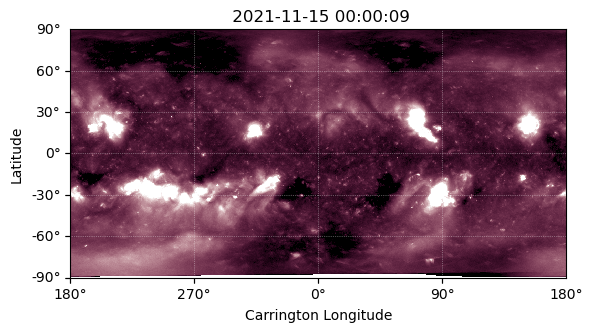

In [13]:
# Next, create an EUV synoptic map centered on perihelion to contextualize the predictions
euv_shape_out = [720, 1440]

angstroms = 211

euvpath = f"./{perihelia[9].date()}_{angstroms}.fits"
if not os.path.exists(euvpath) :
    maps_in_aia = []
    for dt in h.gen_dt_arr(perihelia[9]-timedelta(days=14),
                         perihelia[9]+timedelta(days=14)
                           ) :
        try : 
            maps_in_aia.append(
                reproject_carrington(
                    aia_start_of_day_map(dt, angstroms * u.Angstrom),
                    euv_shape_out
                ))
        except RuntimeError as e : print(f"{dt} : {e}")

    euvmap = pfsspy.utils.roll_map(coadd(maps_in_aia, 
                       weight_function=weight_function),
                       lh_edge_lon=180*u.deg
                                     )

    euvmap.save(euvpath)
else : euvmap = sunpy.map.Map(euvpath)
carr_header = sunpy.map.header_helper.make_heliographic_header(
    aiamap.date, aiamap.observer_coordinate, euv_shape_out, frame='carrington'
)
euvmap_ = sunpy.map.Map(euvmap.data,carr_header)
euvmap_.plot(cmap="sdoaia211",clip_interval=[5,98]*u.percent)

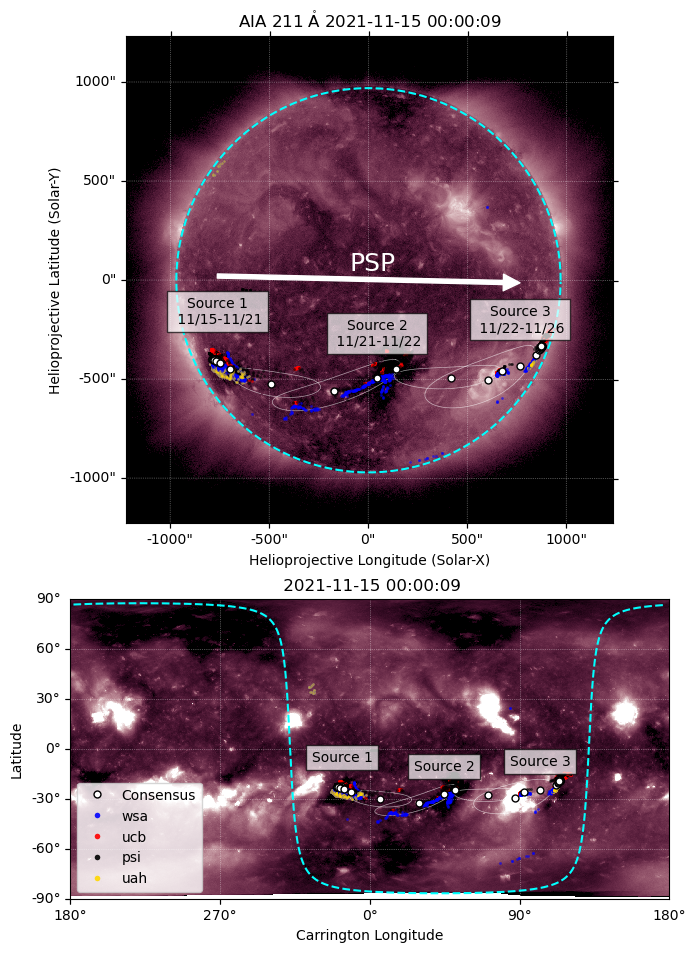

In [14]:
source_dict = {"wsa":"blue","ucb":"red","psi":"black","uah":"gold"}

## Create Plot
fig = plt.figure(figsize=(12,10))
gs = fig.add_gridspec(5, 1)

## Get limb for annotation
limb = sunpy.coordinates.utils.get_limb_coordinates(
    aiamap.observer_coordinate, aiamap.rsun_meters, 1000
    )

## Draw background helioprojective image
axhp = fig.add_subplot(gs[0:3],projection=aiamap)
aiamap.plot(axes=axhp,clip_interval=[27,100]*u.percent)
axhp.plot_coord(limb,color="cyan",linestyle="--")

## Draw background heliographic image
axcarr = fig.add_subplot(gs[3:],projection=euvmap_)
euvmap_.plot(axes=axcarr,cmap="sdoaia211",clip_interval=[5,98]*u.percent)
limb_carr = limb.transform_to(euvmap_.coordinate_frame)
limb_carr = limb_carr[np.argsort((limb_carr.lon.value+180)%360-180)]
axcarr.plot_coord(limb_carr,color="cyan",linestyle="--")


## Create grid on which to evaluate pdf
uc,vc = np.meshgrid(np.linspace(0.5,359.5,360)*u.deg,
                    np.linspace(-89.5,89.5,180)*u.deg)
xc,yc,zc = np.array([[np.cos(uc)*np.cos(vc)],
                     [np.sin(uc)*np.cos(vc)],
                     [np.sin(vc)]
                    ])

## Plot raw distributions
for window,distribution in predictions_dict[enc][update].items():
    if (len(distribution) > 10) & (window > tfocus[0]) & (window < tfocus[-1]): 
        # Cast Ensemble to SkyCoord
        ensemble = h.carr2SkyCoord(distribution.lons.values*u.deg,
                                 distribution.lats.values*u.deg,
                                 [1*u.R_sun]*len(distribution),
                                 update
                                )        
        for source,col in source_dict.items() :
            filter1 = distribution.fnames.str.contains(source) 
            filter2 = (ensemble.transform_to(aiamap.reference_coordinate).distance.to("R_sun").value
                        < aiamap.observer_coordinate.radius.to("R_sun").value
                      )
            if np.any(filter1) :
                if np.any(filter1 & filter2): axhp.plot_coord(ensemble[filter1 & filter2],
                              "o",ms=2,alpha=0.6,c=col,linestyle="None",
                              mec="None",zorder=3
                             )
                axcarr.plot_coord(ensemble[filter1],
                              "o",ms=2,alpha=0.6,c=col,linestyle="None",
                              mec="None",zorder=3
                             )

## Plot consensus
axhp.plot_coord(
    centroids_sc[centroids_sc.transform_to(aiamap.reference_coordinate).distance < aiamap.observer_coordinate.radius],
    "o",ms=5,alpha=1,c="white", mec="black",linestyle="None",zorder=4,label="Consensus"
)
axcarr.plot_coord(
    centroids_sc,
    "o",ms=5,alpha=1,c="white", mec="black",linestyle="None",zorder=4,label="Consensus"
)

## Plot FWHM contours
for contourset in fwhm_contours :
    if contourset is not None :
        for contour in contourset :
            contourh = contour.transform_to(aiamap.reference_coordinate)
            filter_ = contourh.distance < aiamap.observer_coordinate.radius
            if np.any(filter_) : axhp.plot_coord(contourh[filter_],
                                                 color="white",linewidth=0.5,alpha=0.6
                                                )
            axcarr.plot_coord(contourh,
                              color="white",linewidth=0.5,alpha=0.6
                             )

            
source_coords = centroids_sc[[0,16,21]]
for ii,(sc,[ds,de]) in enumerate(zip(
    source_coords,[["11/15","11/21"],
                   ["11/21","11/22"],
                   ["11/22","11/26"]
                  ])
) :
    for ax in axhp,axcarr :
        pix = ax.wcs.world_to_pixel(sc)
        label = f"Source {ii+1}"
        if ax==axhp : label += f"\n {ds}-{de}"
        ax.text(pix[0],pix[1]*1.2,label,
                  rotation=0,
                  horizontalalignment="center",
                  verticalalignment="bottom",
                  color="black",bbox={"facecolor":"white",
                                      "edgecolor":"black",
                                      "alpha":0.7
                                     }
                 )
pixh = axhp.wcs.world_to_pixel(source_coords[-1])
pixf = axhp.wcs.world_to_pixel(source_coords[0])
axhp.annotate(
    "",(pixh[0],pixh[1]+700),(pixf[0],pixf[1]+700),zorder=10,arrowprops={"color":"white","width":3},
)
axhp.text(
    (pixh[0]+pixf[1])/2.5,pixh[1]+800, "PSP", 
    color="white",
    horizontalalignment="left",
    fontsize=18
)
            
## Dummy points for legend
for source,col in source_dict.items() :
    axcarr.plot([]*u.pixel,[]*u.pixel,
            linestyle="None",
            marker="o",ms=4,mec="None",alpha=0.9,c=col,label=source)
axcarr.legend(loc=3)

plt.tight_layout(pad=4)

plt.savefig("./Figure3.png",dpi=200,bbox_inches="tight")

### Figure 4 : Temporal to Spatial Mapping

Plot which illustrates the in situ timeseries from this encounter used in this work for source comparison and global corona structure inference, and a separate column of panels showing the distortion when the data is cast to spatial coordinates instead of temporal due to PSP's varying angular motion in the solar corotating frame.

In [15]:
## First Download Datasets and load into memory
# Note this will download to the same location as this notebook, in a folder
# ./psp_data/ ; after running for the first time, this will automatically
# check the cdf files exist already and not repeat any downloads.
trange = [
    (perihelia[9]-timedelta(days=28)),
    (perihelia[9]+timedelta(days=28)),
]
trange_str = [t.strftime('%Y/%m/%d') for t in trange]


# FIELDS/MAG/RTN_1min
mag_vars = pyspedas.psp.fields(trange=trange_str, 
                               datatype='mag_rtn_1min', 
                               level='l2', time_clip=True)

# FIELDS/RFS/QTN
qtn_vars = pyspedas.psp.fields(trange=trange_str, 
                               datatype='sqtn_rfs_v1v2', 
                               level='l3', time_clip=True)

# SWEAP/SPI/VRTN
spi_vars = pyspedas.psp.spi(trange=trange_str, 
                            datatype='spi_sf00_l3_mom', 
                            level='l3', time_clip=True)

01-Feb-23 15:21:07: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2021/
01-Feb-23 15:21:07: File is current: psp_data/fields/l2/mag_rtn_1min/2021/psp_fld_l2_mag_rtn_1min_20211024_v02.cdf
01-Feb-23 15:21:07: File is current: psp_data/fields/l2/mag_rtn_1min/2021/psp_fld_l2_mag_rtn_1min_20211025_v02.cdf
01-Feb-23 15:21:07: File is current: psp_data/fields/l2/mag_rtn_1min/2021/psp_fld_l2_mag_rtn_1min_20211026_v02.cdf
01-Feb-23 15:21:07: File is current: psp_data/fields/l2/mag_rtn_1min/2021/psp_fld_l2_mag_rtn_1min_20211027_v02.cdf
01-Feb-23 15:21:07: File is current: psp_data/fields/l2/mag_rtn_1min/2021/psp_fld_l2_mag_rtn_1min_20211028_v02.cdf
01-Feb-23 15:21:08: File is current: psp_data/fields/l2/mag_rtn_1min/2021/psp_fld_l2_mag_rtn_1min_20211029_v02.cdf
01-Feb-23 15:21:08: File is current: psp_data/fields/l2/mag_rtn_1min/2021/psp_fld_l2_mag_rtn_1min_20211030_v02.cdf
01-Feb-23 15:21:08: File is current: psp_data/fields/l2/mag_rtn_1min/2021/psp_fl

ConnectionError: HTTPSConnectionPool(host='spdf.gsfc.nasa.gov', port=443): Max retries exceeded with url: /pub/data/psp/fields/l2/mag_rtn_1min/2021/psp_fld_l2_mag_rtn_1min_20211204_v02.cdf (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f64bfb447f0>: Failed to establish a new connection: [Errno 101] Network is unreachable'))

In [ ]:
## Extract into numpy arrays

# br
_brtn = pytplot.get_data('psp_fld_l2_mag_RTN_1min')
tb,[br,bt,bn] = _brtn.times,_brtn.y.T
dtb = h.unix2datetime(tb)


# ne
_ne = pytplot.get_data('electron_density')
tn,ne = _ne.times,_ne.y
dtn = h.unix2datetime(tn)

# vr
_vrtn = pytplot.get_data('psp_spi_VEL_RTN_SUN')
tv,[vr,vt,vn] = _vrtn.times,_vrtn.y.T
dtv = h.unix2datetime(tv)

In [ ]:
## Linearly interpolate to common time base (5 min cadence) over the superotation period of E10
dt_common = h.gen_dt_arr(tfocus[0],
                         tfocus[-1],
                         cadence_days=1/24/12
                        )
ut_common = h.datetime2unix(dt_common)
br_common = interp1d(tb[~np.isnan(br)],br[~np.isnan(br)],
                     bounds_error=False)(ut_common)*u.nT
ne_common = interp1d(tn[~np.isnan(ne)],ne[~np.isnan(ne)],
                     bounds_error=False)(ut_common)*u.cm**-3
vr_common = interp1d(tv[~np.isnan(vr)],vr[~np.isnan(vr)],
                     bounds_error=False)(ut_common)*u.km/u.s

In [ ]:
## Compute Alfven Speed
va_common = (np.abs(br_common)/(const.mu0*const.m_p*ne_common)**0.5).to("km/s")

## Compute Alfven Mach number
ma_common = vr_common/va_common

In [ ]:
## Produce PSP trajectory and source surface trajectory for given timebase
psp_common_inertial = astrospice.generate_coords(
    'SOLAR PROBE PLUS',dt_common
)
### Transform to solar co-rotating frame (SLOW)
psp_common = psp_common_inertial.transform_to(
    sunpy.coordinates.HeliographicCarrington(observer="self")
)
psp_common.representation_type="spherical"
psp_projected_common = h.ballistically_project(psp_common, vr_arr=vr_common)

In [ ]:
## Also make full version to show HCS crossings later at 10min cadece
dt_common_long = h.gen_dt_arr(
    trange[0], trange[-1], cadence_days=1/24/6
    )
ut_common_long = h.datetime2unix(dt_common_long)
br_common_long = interp1d(tb[~np.isnan(br)],br[~np.isnan(br)],
                     bounds_error=False)(ut_common_long)*u.nT
ne_common_long = interp1d(tn[~np.isnan(ne)],ne[~np.isnan(ne)],
                     bounds_error=False)(ut_common_long)*u.cm**-3
vr_common_long = interp1d(tv[~np.isnan(vr)],vr[~np.isnan(vr)],
                     bounds_error=False)(ut_common_long)*u.km/u.s
## Compute Alfven Speed
va_common_long = (np.abs(br_common_long)/(const.mu0*const.m_p*ne_common_long)**0.5).to("km/s")

## Compute Alfven Mach number
ma_common_long = vr_common_long/va_common_long

## Produce PSP trajectory and source surface trajectory for given timebase
psp_common_long_inertial = astrospice.generate_coords(
    'SOLAR PROBE PLUS',dt_common_long
)
### Transform to solar co-rotating frame (SLOW)
psp_common_long = psp_common_long_inertial.transform_to(
    sunpy.coordinates.HeliographicCarrington(observer="self")
)
psp_common_long.representation_type="spherical"
psp_projected_common_long = h.ballistically_project(psp_common_long, vr_arr=vr_common_long)

In [ ]:
## Do plot
fig,axes = plt.subplots(figsize=(12,8),nrows=4,ncols=2)

for ii,([axl,axr],dat,cvec,ylab) in enumerate(zip(
    axes, [br_common,ne_common,vr_common,ma_common],
    [plt.cm.bwr(plt.Normalize(-1,1)(np.sign(br_common))),
     plt.cm.plasma(plt.Normalize(1,5000)(ne_common)),
     plt.cm.inferno(plt.Normalize(200,800)(vr_common)),
     plt.cm.PuOr_r(plt.Normalize(0.8,1.2)(ma_common))],
    ["$B_R$ (nT)","$N_e$ (cm$^{-3}$)", "V$_\mathrm{sw}$ (km/s)","$M_A$"]
    )) :
    axl.scatter(dt_common,dat,c=cvec,s=5)
    axl.set_xlim(dt_common[0],dt_common[-1])
    axr.scatter(h.rollto180(psp_projected_common.lon),dat,c=cvec,s=5)
    axr.set_xlim([np.nanmin(h.rollto180(psp_projected_common.lon)).value-5,
                 np.nanmax(h.rollto180(psp_projected_common.lon)).value+5
                ])
    axl.set_ylabel(ylab)
    axl.grid()
    axr.grid()
    axr.set_yticklabels("")
    if ii <3 : 
        axl.set_xticklabels("")
        axr.set_xticklabels("")
for ax,xlab in zip(axes[-1],["Time","Ballistically projected longitude (deg)"]) : 
    ax.set_ylim([0,10])
    ax.axhline(1,color="black",linestyle="--")
    ax.set_xlabel(xlab)
for ax in axes[:,-1] : ax.set_xticks(np.linspace(-30,150,7))

for ax in axes[:,0] :
    ax.axvspan(datetime(2021,11,20,17),
               datetime(2021,11,20,21),
               alpha=0.3)
    ax.axvspan(datetime(2021,11,21,16,30),
               datetime(2021,11,22,6),
               alpha=0.3)

for ax in axes[:,1] :
    ax.axvspan(11,16,alpha=0.3)
    ax.axvspan(80,105,alpha=0.3)    
    
for ii,dt in enumerate([datetime(2021,11,19), 
                        datetime(2021,11,21,7),
                        datetime(2021,11,24)]) :
    ind = np.where(dt_common > dt)[0][0]
    axes[0,0].text(dt,80,f"Stream {ii+1}",
                   horizontalalignment="center")
    if ii == 0 : axes[0,1].text(h.rollto180(psp_common.lon)[ind].value,80,f"Stream {ii+1}",
                   horizontalalignment="left")
    else : axes[0,1].text(h.rollto180(psp_common.lon)[ind].value,80,f"Stream {ii+1}",
                   horizontalalignment="center")
    
plt.tight_layout()

plt.savefig("./Figure4.png",dpi=200)

### Figure 5 : E10 In Situ - Footpoint Correspondence

Plot which shows the spatial correspondence of the in situ data and the footpoints as derived from a PFSS footpoint estimate which well describes (1) the footpoint predictions and (2) predicts a consistent (negative) polarity throughout the encounter, and therefore validates the predictions in a novel and useful way.

In [ ]:
# Download magnetogram for 2021/11/21
filename = "adapt40311_03k012_202111210800_i00051600n1.fts.gz"
filename = "adapt40311_03k012_202111150800_i00005500n1.fts.gz"
remote_path = "https://gong.nso.edu//adapt/maps/gong/2021"
local_path = "."
if not os.path.exists(f"./{filename}") :
    urllib.request.urlretrieve(f"{remote_path}/{filename}", 
                               f"{local_path}/{filename}"
                              )

In [ ]:
# Run PFSS Model
pfss_model = h.adapt2pfsspy(filename, rss=2.5)

# Produce coronal hole map (Trace over grid then extract field line topology)
# Use same pixel binning as we did for the EUV map earlier to make a sunpy.map
# Note: Fortran tracer / python bridge leaks memory so don't run very many times.
carr_header = sunpy.map.header_helper.make_heliographic_header(
    update, aiamap.observer_coordinate, [180,360], frame="carrington"
)
carr_header["crval1"] = 180 # Make sunpy realize left hand edge is 0 deg lon
chmap = pfsspy.utils.roll_map(sunpy.map.Map(
    h.pfss2flines(
        pfss_model,
        rect = [-89.5,89.5,0.5,359.5],
        nth=180,nph=360
        ).polarities.reshape([180,360]),
    carr_header
), lh_edge_lon=180*u.deg)

# Trace PSP field lines
flines_psp = h.pfss2flines(pfss_model,skycoord_in=psp_projected_common)

In [ ]:
# Project Carrington map  of coronal holes into helioprojective 
# view for 11/15. Separate cell since its slow
chmap_heliop = chmap.reproject_to(aiamap.wcs)

In [ ]:
## Compare coronal hole map from model to EUV data
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(221,projection=aiamap.wcs)
chmap_heliop.draw_limb(axes=ax1,color="cyan",linestyle="--")
chmap_heliop.draw_grid(axes=ax1)
chmap_heliop.plot(cmap="coolwarm",axes=ax1)

ax2 = fig.add_subplot(222,projection=aiamap.wcs)
aiamap.plot(axes=ax2)
aiamap.draw_grid(axes=ax2,alpha=0.2)
aiamap.draw_limb(axes=ax2,color="cyan",linestyle="--")
ax2.coords.grid(False)

ax3 = fig.add_subplot(223,projection=chmap.wcs)
chmap.draw_limb(axes=ax3,color="cyan",linestyle="--")
chmap.plot(cmap="coolwarm",axes=ax3)

ax4 = fig.add_subplot(224,projection=euvmap_.wcs)
euvmap_.plot(axes=ax4,cmap="sdoaia211",clip_interval=[0.1,95]*u.percent)
euvmap_.draw_limb(axes=ax4,color="cyan",linestyle="--")

plt.tight_layout(pad=6)

In [ ]:
fig = plt.figure(figsize=(20,20))

# Reproject to sine(latitude) binning to better show the
# spacecraft trajectory
chmap_cea = pfsspy.utils.car_to_cea(chmap)
ax = fig.add_subplot(223,projection=chmap_cea.wcs)

# Plot the coronal hole map
chmap_cea.plot(cmap="coolwarm",axes=ax)

# Plot the HCS/neutral line
pilsc = pfss_model.source_surface_pils[0]
pil = h.carr2SkyCoord(pilsc.lon[np.argsort(h.rollto180(pilsc.lon))],
                      pilsc.lat[np.argsort(h.rollto180(pilsc.lon))],
                      pilsc.radius[np.argsort(h.rollto180(pilsc.lon))],
                      chmap.date
                     )
ax.plot_coord(pil,color="black",linestyle="--",linewidth=0.4)

# Plot PSP's trajectory colorized by the measured polarity
psp_p = chmap_cea.world_to_pixel(
        h.carr2SkyCoord(
            psp_projected_common.lon,
            psp_projected_common.lat,
            psp_projected_common.radius,
            chmap.date
        )
    )
psp_long_p = chmap_cea.world_to_pixel(
        h.carr2SkyCoord(
            psp_projected_common_long.lon,
            psp_projected_common_long.lat,
            psp_projected_common_long.radius,
            chmap.date
        )
    )
ax.scatter(psp_p.x,psp_p.y, c=plt.cm.bwr(np.sign(br_common)),s=4)
ax.scatter(psp_p.x[::12*6],psp_p.y[::12*6],
           c="white",s=100,marker="|",ec="white",zorder=5)
for dt,x,y in zip(dt_common[3*12*24:6*12*24:12*12],
                  psp_p.x[3*12*24:6*12*24:12*12],
                  psp_p.y[3*12*24:6*12*24:12*12],
                 ) :
    ax.text(x.value,y.value,dt.strftime("%m/%d:%H:%M"),
            color="black",
            rotation=45,
            zorder=10,
            fontsize=10,
            horizontalalignment="right",
            verticalalignment="top",
            bbox={"ec":"black","fc":"white","alpha":0.5}
           )

# Plot the field lines colorized by the modeled polarity
for f,c in zip(flines_psp[::12],
               plt.cm.bwr(flines_psp.polarities)[::12]) :
    f_to_plot = h.carr2SkyCoord(
        f.coords.lon,f.coords.lat,f.coords.radius,chmap.date
    )
    if len(f_to_plot) > 0 : 
        ax.plot_coord(f_to_plot,color=c,lw=0.5,alpha=0.5)
        
ax.set_title("ADAPT-GONG PFSS Model for 2021/11/15")
        
# Add trace which shows velocity stream structure
vcurve_p = chmap_cea.world_to_pixel(
        h.carr2SkyCoord(
            psp_projected_common.lon,
            psp_projected_common.lat+(vr_common.value-100)/600 * 7 *u.deg,#-15*u.deg,
            psp_projected_common.radius,
            chmap.date
        )
    )

ax.scatter(vcurve_p.x,vcurve_p.y, 
           c=plt.cm.inferno(plt.Normalize(200,800)(vr_common.value)),s=4,
           zorder=5
          )

ax.set_xlim(*chmap_cea.world_to_pixel(h.carr2SkyCoord(
    [-45,155]*u.deg,[0,0]*u.deg,[1,1]*u.R_sun,chmap.date
)).x.value)

ax.plot_coord(
    centroids_sc,
    "o",ms=5,alpha=1,c="white", 
    mec="black",linestyle="None",zorder=4,label="Consensus"
)

stream_labels = chmap_cea.world_to_pixel(
        h.carr2SkyCoord(
            [345,35,115]*u.deg,
            [13,5,5]*u.deg,
            [1,1,1]*u.R_sun,
            chmap.date,
        )
    )
for ii,(slx,sly) in enumerate(zip(stream_labels[0],
                                stream_labels[1])) :
    print(slx,sly)
    ax.text(slx.value,sly.value,f"Stream {ii+1}",
            horizontalalignment="center"
           )

plt.savefig("./Figure5.png",dpi=200,bbox_inches="tight")

### Figure 6 : E04 - E10 Comparison - HCS Geometry and Footpoint Conensus

Plot similar to fig 3, right hand panel but for E04 and E10, and including a representative HCS for both, and PFSS coronal hole contours. The plot illustrsates that E04 predictions were quite evenly bifurcates to very different source locations due to a flat HCS and dominant polar coronal holes and therefore were much higher in uncertainty than in E10 where strong warps in the HCS and equatorial coronal holes provide much more robust source estimation. 

In [ ]:
# Run PFSS for E04

# Download magnetogram for 2020/01/10
filename_e04 = "adapt40311_03k012_202001230800_i00005600n1.fts.gz"
remote_path_e04 = "https://gong.nso.edu//adapt/maps/gong/2020"
local_path = "."
if not os.path.exists(f"./{filename_e04}") :
    urllib.request.urlretrieve(f"{remote_path_e04}/{filename_e04}", 
                               f"{local_path}/{filename_e04}"
                              )
    
filename_e04_hmi = "adapt40411_03l012_202001230800_i00030000n1.fts.gz"
remote_path_e04_hmi = "https://gong.nso.edu//adapt/maps/special/psp/adapt_hmi-los"
local_path = "."
if not os.path.exists(f"./{filename_e04_hmi}") :
    urllib.request.urlretrieve(f"{remote_path_e04_hmi}/{filename_e04_hmi}", 
                               f"{local_path}/{filename_e04_hmi}"
                              )

filename_e10_hmi = "adapt40411_03l012_202111150800_i00010000n1.fts.gz"
remote_path_e10_hmi = "https://gong.nso.edu//adapt/maps/special/psp/adapt_hmi-los"
local_path = "."
if not os.path.exists(f"./{filename_e10_hmi}") :
    urllib.request.urlretrieve(f"{remote_path_e10_hmi}/{filename_e10_hmi}", 
                               f"{local_path}/{filename_e10_hmi}"
                              )    
    
# Run PFSS Model
pfss_model_e04 = h.adapt2pfsspy(filename_e04, rss=2.5)
pfss_model_e04_hmi = h.adapt2pfsspy(filename_e04_hmi, rss=2.5)
pfss_model_e10_hmi = h.adapt2pfsspy(filename_e10_hmi, rss=2.5)

# Produce coronal hole map (Trace over grid then extract field line topology)
# Use same pixel binning as we did for the EUV map earlier to make a sunpy.map
# Note: Fortran tracer / python bridge leaks memory so don't run very many times.
nph,nth = 360,180
aiamap_e04 = aia_start_of_day_map(pfss_model_e04.source_surface_br.date,211*u.angstrom)
carr_header_e04 = sunpy.map.header_helper.make_heliographic_header(
    aiamap_e04.date, aiamap_e04.observer_coordinate, [nth,nph], frame='carrington'
); carr_header_e04["crval1"] = 180 # Make sunpy realize left hand edge is 0 deg lon

chdat_e04 = h.pfss2flines(
        pfss_model_e04,
        rect = [-89.5,89.5,0.5,359.5],
        nth=nth,nph=nph
        ).polarities.reshape([nth,nph])
chmap_e04 = pfsspy.utils.car_to_cea(pfsspy.utils.roll_map(
    sunpy.map.Map(chdat_e04,carr_header_e04), 
    lh_edge_lon=180*u.deg
))

In [ ]:
# Download magnetic field data for PSP E04
trange = [
    (perihelia[3]-timedelta(days=28)),
    (perihelia[3]+timedelta(days=28)),
]
trange_str = [t.strftime('%Y/%m/%d') for t in trange]

# FIELDS/MAG/RTN_1min
mag_vars = pyspedas.psp.fields(trange=trange_str, 
                               datatype='mag_rtn_1min', 
                               level='l2', time_clip=True)

# br
_brtn04 = pytplot.get_data('psp_fld_l2_mag_RTN_1min')
tb04,[br04,bt04,bn04] = _brtn04.times,_brtn04.y.T
dtb04 = h.unix2datetime(tb04)

psp04 = astrospice.generate_coords(
    'SOLAR PROBE PLUS',dtb04
)
### Transform to solar co-rotating frame (SLOW)
psp04carr = psp04.transform_to(
    sunpy.coordinates.HeliographicCarrington(observer="self")
)
pspss04 = h.ballistically_project(psp04carr)

In [ ]:
source_dict = {"wsa":"blue","ucb":"red","psi":"black","uah":"gold","nso":"purple"}

## Create Plot
fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(2, 1)

## Get limb for annotation
limb = sunpy.coordinates.utils.get_limb_coordinates(
    aiamap.observer_coordinate, aiamap.rsun_meters, 1000
    )

ax04 = fig.add_subplot(gs[0:1],projection=chmap_e04)
chmap_e04.plot(axes=ax04,cmap="coolwarm",vmin=-2,vmax=2)
pil_e04 = pfss_model_e04.source_surface_pils[0]
pil_e04_hmi = pfss_model_e04_hmi.source_surface_pils[0]
ax04.plot_coord(
    h.carr2SkyCoord(pil_e04.lon,pil_e04.lat,pil_e04.radius, aiamap_e04.date),
    "o",linestyle="none",ms=1,color="black"
) 
ax04.plot_coord(
    h.carr2SkyCoord(pil_e04_hmi.lon,pil_e04_hmi.lat,pil_e04_hmi.radius, aiamap_e04.date),
    "o",linestyle="none",ms=0.6,color="grey"
) 

## Plot raw distributions
update_e04 = datetime(2020,1,23)
for window,distribution in predictions_dict["E04"][update_e04].items():
    if (len(distribution) > 1):
        # Cast Ensemble to SkyCoord
        ensemble = h.carr2SkyCoord(distribution.lons.values*u.deg,
                                 distribution.lats.values*u.deg,
                                 [1*u.R_sun]*len(distribution),
                                 chmap_e04.date
                                )        
        for source,col in source_dict.items() :
            filter1 = distribution.fnames.str.contains(source) 
            filter2 = distribution.fnames.str.contains("gong")
            filter3 = distribution.fnames.str.contains("hmi")

            if np.any(filter1 & filter2) :
                if source == "wsa" : raster=24
                else : raster=1
                ax04.plot_coord(ensemble[filter1 & filter2][::raster],
                              "o",ms=7,alpha=0.6,
                              c=col,linestyle="None",
                              mec="None",zorder=3,
                             )
            if np.any(filter1 & filter3) :
                if source == "wsa" : raster=24
                else : raster=1
                ax04.plot_coord(ensemble[filter1 & filter3][::raster],
                              "d",ms=7,alpha=0.6,
                              c=col,linestyle="None",
                              mec="None",zorder=3,
                             )

## Draw background heliographic image
ax10 = fig.add_subplot(gs[1:],projection=chmap_cea)
chmap_cea.plot(axes=ax10,cmap="coolwarm",vmin=-2,vmax=2)

## Plot raw distributions
for window,distribution in predictions_dict["E10"][update].items():
    if (len(distribution) > 1):
        # Cast Ensemble to SkyCoord
        ensemble = h.carr2SkyCoord(distribution.lons.values*u.deg,
                                 distribution.lats.values*u.deg,
                                 [1*u.R_sun]*len(distribution),
                                 update
                                )        
        for source,col in source_dict.items() :
            filter1 = distribution.fnames.str.contains(source) 
            if np.any(filter1) :
                ax10.plot_coord(ensemble[filter1],
                              "o",ms=2,alpha=0.6,
                              c=col,linestyle="None",
                              mec="None",zorder=3
                             )
                
## 
ax10.plot_coord(
    h.carr2SkyCoord(pil.lon,pil.lat,pil.radius, aiamap.date),
    "o",linestyle="none",ms=1,color="black"
) 
pil_e10_hmi = pfss_model_e10_hmi.source_surface_pils[0]
ax10.plot_coord(
    h.carr2SkyCoord(pil_e10_hmi.lon,pil_e10_hmi.lat,pil_e10_hmi.radius, aiamap.date),
    "o",linestyle="none",ms=0.6,color="grey"
) 
                
## Dummy points for legend
source_dict = {"wsa":"blue","ucb":"red","psi":"black","uah":"gold"}
for source,col in source_dict.items() :
    ax10.plot([]*u.pixel,[]*u.pixel,
            linestyle="None",
            marker="o",ms=4,mec="None",alpha=0.9,c=col,label=source)
ax10.legend(loc=3)

source_dict = {"wsa":"blue","ucb":"red","psi":"black","nso":"purple"}
for source,col in source_dict.items() :
    ax04.plot([]*u.pixel,[]*u.pixel,
            linestyle="None",
            marker="o",ms=4,mec="None",alpha=0.9,c=col,label=source)
ax04.scatter([]*u.pixel,[]*u.pixel,fc="none",ec="black",s=20,marker="d",label="HMI")
ax04.scatter([]*u.pixel,[]*u.pixel,fc="none",ec="black",s=20,marker="o",label="GONG")
ax04.legend(loc=3)

ax10.scatter(
    *psp_long_p,
    c=plt.cm.bwr(np.sign(br_common_long)),s=3
)

#psp_e04_projected = h.ballistically_project(psp_carrington_e04)
psp_e04_p = ax04.wcs.world_to_pixel(
    h.carr2SkyCoord(pspss04.lon,
                    pspss04.lat,
                    pspss04.radius,
                    chmap_e04.date)
)
ax04.scatter(
    psp_e04_p[0],#[1*24::-1*24],
    psp_e04_p[1],#[1*24::-1*24],
    c=plt.cm.bwr(np.sign(br04)),s=3
)
ax04.set_title("E04 - ADAPT-GONG 2021/01/23 2.5 $R_\odot$")
ax10.set_title("E10 - ADAPT-GONG 2021/11/15 2.5 $R_\odot$")

plt.tight_layout(pad=5)

plt.savefig("./Figure6.png",dpi=200)

### Figure 7 : E10 Large Scale Structure : Alfven Surface Geometry

Plot showing PSP's motion around the Sun during perihelion colored by Alfven Mach number with a spline showing the Alfven surface crossing the trajectory, as well as an inset zoomed in on the corona which shows how the undulations relate to magnetic separatrices underneath, and therefore allowing the relation of magnetic connectivity to global structure.

In [ ]:
import copy

# Get indices where MA crosses 0
ma_sanitize = copy.copy(ma_common)
ma_sanitize[ma_sanitize>10] = np.nan
ma_smooth = h.smooth(ma_sanitize,4)
ind0 = np.where(np.sign(ma_smooth-1)[:-1]*np.sign(ma_smooth-1)[1:]==-1)[0] 

# Get x,y coords for these points
alfcross = psp_common[ind0]

# Create synthetic curve which passes through those points
alf_modifier = (ma_smooth)
psp_common.representation_type="spherical"
alf_curve = h.carr2SkyCoord(
    psp_common.lon,psp_common.lat,h.smooth(psp_common.radius/alf_modifier**0.7,12),psp_common.obstime
)

In [ ]:
plt.plot(ma_sanitize)
plt.plot(ma_smooth)
plt.gca().axhline(1)

In [ ]:
alf_curve.representation_type="cartesian"
alfcross.representation_type="cartesian"
psp_common.representation_type="cartesian"
plt.scatter(alfcross.x.to("R_sun"),alfcross.y.to("R_sun"),s=50,marker="o",color="white",edgecolor="black")
plt.plot(alf_curve.x.to("R_sun"),alf_curve.y.to("R_sun"),color="blue")
plt.plot(psp_common.x.to("R_sun"),psp_common.y.to("R_sun"),color="black")

In [ ]:
fig = plt.figure(figsize=(7,14))

axes=[]
ax=fig.add_subplot(212)
axes.append(ax)

## Inertial
psp_mission_carrington.representation_type="cartesian"

ax.plot(psp_carrington_e10.x.to("R_sun"),
             psp_carrington_e10.y.to("R_sun"),
             color="black",alpha=0.3,linewidth=2,zorder=3)

ax.set_xlabel("X-Carr ($R_\odot$)")
ax.set_ylabel("Y-Carr ($R_\odot$)")
ax.set_title("Carrington Coordinates")


ax.axvline(0,color="grey",linestyle=":")
ax.axhline(0,color="grey",linestyle=":")
## Polar gridlines 
for R_ in np.linspace(15,60,4) :
    ax.plot(R_*np.cos(np.linspace(0,2*np.pi,200)),
            R_*np.sin(np.linspace(0,2*np.pi,200)),
            color="black",linestyle="--",alpha=0.5,linewidth=0.8
           )
    if R_ < 60 : ax.text(R_*np.cos(np.radians(30)),
                          R_*np.sin(np.radians(30)),
                          f"{R_:.0f}",
                          horizontalalignment="center",
                          verticalalignment="center"
                         )

for phi in np.radians(np.linspace(0,360,13)) :
    ax.plot([0,120*np.cos(phi)],[0,120*np.sin(phi)],
            color="black",linestyle="--",alpha=0.5,linewidth=0.8
           )
ax.set_xlim([-20,50])
ax.set_ylim([-20,50])
ax.set_xticks([])
ax.set_yticks([])
    
psp_common.representation_type="cartesian"
ma=ax.scatter(psp_common.x.to("R_sun")[::12],
           psp_common.y.to("R_sun")[::12],
           c=ma_common[::12],
           cmap = plt.cm.PuOr_r,
           norm = plt.Normalize(0.5,1.5),
           s=50,marker="o"
          )
cb=plt.colorbar(ma,ax=ax)
cb.set_label("Alfven Mach Number",fontsize=18)
ax.set_aspect(1)

alf_curve.representation_type="cartesian"
alfcross.representation_type="cartesian"
psp_common.representation_type="cartesian"
ax.plot(alf_curve.x.to("R_sun"),alf_curve.y.to("R_sun"),color="black",zorder=5)

plt.tight_layout(pad=-2)

# Create box zoom to show coronal field (PFSS tutorial)
left,right,bottom,top=[-5.8,5.8,-5.8,5.8]
back,front = [-5.8,5.8]
ax2 = fig.add_subplot(211,projection="3d")
axes.append(ax2)
ax2.set_xlim([left+1.5,right-1.5])
ax2.set_ylim([back+1.5,front-1.5])
ax2.set_zlim([bottom+1.5,top-1.5])

# Add rectangle for zoomed box
axes[0].add_patch(mpatch.Rectangle((left, bottom),
                             right - left,
                             top - bottom, facecolor='none',
                             linewidth=2, edgecolor='black',zorder=100))#

# Plot CHMAP in 3D
axes[1].plot(
    np.cos(np.linspace(0,360,100)*u.deg),
    np.sin(np.linspace(0,360,100)*u.deg),
    color="black",linestyle="--"
)
cols = plt.cm.bwr(plt.Normalize(-1,1)(chmap.data))
cols[:,:,-1] = np.abs(chmap.data)
ucroll,vcroll = np.meshgrid(np.linspace(-179.5,179.5,360),
                            np.linspace(-89.5,89.5,180))*u.deg
xcroll,ycroll,zcroll = np.array([[np.cos(ucroll)*np.cos(vcroll)],
                     [np.sin(ucroll)*np.cos(vcroll)],
                     [np.sin(vcroll)]
                    ])
ax2.scatter(
    xcroll, ycroll, zcroll,
    c=chmap.data,
    cmap="bwr",
    norm=plt.Normalize(-1,1),
    zorder=1,
    alpha=0.5,
    s = np.abs(chmap.data)*20+0.5
)

# Draw PFSS field lines
for f,ma in zip(flines_psp[::6],ma_smooth[::6]) :
    coord = f.coords
    coord.representation_type="cartesian"
    axes[1].plot(
        coord.x.to("R_sun"),
        coord.y.to("R_sun"),
        coord.z.to("R_sun"),
        color=plt.cm.PuOr_r(plt.Normalize(0.5,1.5)(ma)),
        zorder=20,
        alpha=0.9,
    )
    ss = f.source_surface_footpoint
    ss.representation_type="cartesian"
    axes[1].plot(
        ss.x.to("R_sun")*np.array([1,2]),
        ss.y.to("R_sun")*np.array([1,2]),
        ss.z.to("R_sun")*np.array([1,2]),
        color=plt.cm.PuOr_r(plt.Normalize(0.5,1.5)(ma)),
        zorder=20,
        alpha=0.9,
    )
    axes[0].plot(
        coord.x.to("R_sun"),
        coord.y.to("R_sun"),
        color=plt.cm.PuOr_r(plt.Normalize(0.5,1.5)(ma)),
        zorder=20,
        alpha=0.9,
    )
    ss = f.source_surface_footpoint
    ss.representation_type="cartesian"
    axes[0].plot(
        ss.x.to("R_sun")*np.array([1,2]),
        ss.y.to("R_sun")*np.array([1,2]),
        color=plt.cm.PuOr_r(plt.Normalize(0.5,1.5)(ma)),
        zorder=20,
        alpha=0.9,
    )
    

ax2.view_init(30,45)
ax2.set_xlabel("X-Carr (Rs)")
ax2.set_ylabel("Y-Carr (Rs)")
ax2.set_zlabel("Z-Carr (Rs)")
# Shade wedge whiich contains both sub-alf cross

# Maybe add Parker spiral field lines to both colorized by velocity
psp_projected_common.representation_type="cartesian"
ax2.plot(psp_projected_common.x.to("R_sun")[600:-825:10].value*2.1,
         psp_projected_common.y.to("R_sun")[600:-825:10].value*2.1,
         psp_projected_common.z.to("R_sun")[600:-825:10].value*2.1,
         color="black",linestyle="--"
        )
ax2.text(5,5,0,"PSP Motion",zdir=(-1.5,1,0),fontsize=10,
         bbox=dict(boxstyle="rarrow,pad=0.1",fc="white",ec="black",lw=2))

ax.text(5,5,"PSP Motion",fontsize=10, rotation=-45,verticalalignment="center",horizontalalignment="center",
         bbox=dict(boxstyle="larrow,pad=0.1",fc="white",ec="black",lw=2),zorder=100)

ax.plot(psp_projected_common.x.to("R_sun")[600:-700].value*2.1,
         psp_projected_common.y.to("R_sun")[600:-700].value*2.1,
         color="black",linestyle="--"
        )
sun=plt.Circle((0,0),radius=1,fc="white",ec="black",visible=True,zorder=100,lw=2,ls="-")
ax.add_patch(sun)

ax2.text(
    2,-2,-1,"Source 1",
    bbox={"fc":"white","ec":"black","alpha":0.8},zorder=50
)
ax2.text(
    1.5,1.5,-1,"Source 2",
    bbox={"fc":"white","ec":"black","alpha":0.8},zorder=50
)
ax2.text(
    -3,1,-1,"Source 3",
    bbox={"fc":"white","ec":"black","alpha":0.8},zorder=50
)

ax.text(
    29,-4,"Stream 1",
    bbox={"fc":"white","ec":"black","alpha":0.8},
    zorder=50,rotation=45,verticalalignment="bottom",horizontalalignment="right"
)
ax.text(
    16,12,"Stream 2",
    bbox={"fc":"white","ec":"black","alpha":0.8},
    zorder=50,rotation=45,verticalalignment="bottom",horizontalalignment="right"
)
ax.text(
    -4,26,"Stream 3",
    bbox={"fc":"white","ec":"black","alpha":0.8},
    zorder=50,rotation=45,verticalalignment="bottom",horizontalalignment="right"
)

ax.plot(psp_projected_common.x.to("R_sun")[600:-700].value*2.1,
         psp_projected_common.y.to("R_sun")[600:-700].value*2.1,
         color="black",linestyle="--"
        )
sun=plt.Circle((0,0),radius=1,fc="white",ec="black",visible=True,zorder=100,lw=2,ls="-")
ax.add_patch(sun)



plt.savefig("./Figure7.png",dpi=200,bbox_inches="tight")
